In [1]:
import GPy, GPyOpt
import numpy as np
import pandas as pds
import random
import datetime
import time
import os
import matplotlib.pyplot as plt
import logging
import traceback

#from tensorflow.keras.layers import Lambda
from keras.layers import Activation, Dropout, BatchNormalization, Dense, RepeatVector, Bidirectional
from keras.models import Sequential
from keras.datasets import mnist
from keras.metrics import categorical_crossentropy
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Flatten
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from numpy import array
from numpy import hstack
import h5py
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.initializers import RandomUniform
from keras import optimizers
#random.seed(42)
import seaborn as sns
sns.set()

Using TensorFlow backend.


### Load Data Set

In [2]:
#file locations, features and target
feature_dict = {}
target_state_dict={}

path_to_file = "C:\\Users\\mooc\\Documents\\Bosch-MT\\Daten\\UCI_machine_learning_repository\\Condition_hydraulic_systems_data_set"
target_filename = "profile.txt"

feature_list = ['PS1', 'PS2', 'PS3', 'PS4', 'PS5', 'PS6', 'EPS1', 'FS1', 'FS2', 'TS1', 'TS2', 'TS3', 'TS4', 'VS1', 'CE', 'CP', 'SE']
target_list = ['cooler cond.', 'valve cond.', 'pump leakage', 'hydraulic accum.', 'stable flag' ]

target_state_dict['stable flag']=[0,1 ]
target_state_dict['pump leakage']=[0,1,2]
target_state_dict['cooler cond.']=[3,20,100]
target_state_dict['valve cond.']=[73,80,90,100]
target_state_dict['hydraulic accum.']=[90,100,115,130]


leakage_key_list=['c100_h130_pl0_v100_s0', 'c100_h130_pl1_v100_s0', 'c100_h130_pl2_v100_s0']
valve_key_list=['c100_h130_pl0_v100_s0', 'c100_h130_pl0_v90_s0', 'c100_h130_pl0_v80_s0', 'c100_h130_pl0_v73_s0' ]
hydraulic_key_list=['c100_h130_pl0_v100_s0', 'c100_h115_pl0_v100_s0', 'c100_h100_pl0_v100_s0', 'c100_h90_pl0_v100_s0']
stable_key_list=['c100_h130_pl0_v100_s0', 'c100_h130_pl0_v100_s1']
cooler_key_list=['c100_h130_pl0_v100_s0', 'c20_h130_pl0_v100_s0', 'c3_h130_pl0_v100_s0']

all_key_list=['c100_h130_pl0_v100_s0', 'c100_h130_pl1_v100_s0', 'c100_h130_pl2_v100_s0',
              'c100_h130_pl0_v100_s0', 'c100_h130_pl0_v90_s0', 'c100_h130_pl0_v80_s0', 'c100_h130_pl0_v73_s0',
              'c100_h130_pl0_v100_s0', 'c100_h115_pl0_v100_s0', 'c100_h100_pl0_v100_s0', 'c100_h90_pl0_v100_s0',
              'c100_h130_pl0_v100_s0', 'c100_h130_pl0_v100_s1',
              'c100_h130_pl0_v100_s0', 'c20_h130_pl0_v100_s0', 'c3_h130_pl0_v100_s0'
             ]

train_key = ['c100_h130_pl0_v100_s0']

### Data Preprocessing and Preparation

In [3]:
def create_target_dict(target_list, target_filename, path_to_file):
    #read in target values from target file
    
    target_dict = {}
    target_dict = {key: [] for key in target_list}
    target_file = os.path.join(path_to_file, target_filename)

    with open(target_file) as f:
        for line in f:
            value = line.split()
            for i in range(0, len(value)):
                #value_list =[]
                #for j in range(0,6000):
                #    value_list.append(int(value[i]))
            
                #print(len(value_list))
                target_dict[target_list[i]].append(int(value[i]))
                
    return target_dict 

In [4]:
def create_feature_dict(feature_list, path_to_file):
    for f in feature_list:
        file_name = os.path.join(path_to_file, "%s.txt" %(f)) 
        
        with open(file_name) as file:
            #print(f)
            feature_dict[f]= [[float(digit) for digit in line.split()] for line in file]
    
    return feature_dict   

In [5]:
def create_target_tensor(target_dict, target_list, feature_list):
    #create target tensor
    #print(len(target_dict[target_list[0]]))

    n_trows = len(target_dict[target_list[0]])
    n_tcolumns = len(feature_dict[feature_list[0]][0])
    n_targets = len(target_list)
    #print("Dimensions: %s, %s, %s" %(n_trows, n_tcolumns, n_targets))

    target_2d = np.zeros((2205,6000))
    target_value_list = list(target_dict.values())


    for target in range(0, n_targets):
        for row in range(0, n_trows):
                     for column in range(0,n_tcolumns):
                         target_2d[row][column]=target_value_list[target][row]

        if target == 0:
            target_tensor= np.copy(target_2d)
        else:
            target_tensor = np.dstack((target_tensor,target_2d))
                    

    #print("target_sensor shape: " + str(target_tensor.shape))
    return target_tensor

In [6]:
def create_feature_tensor(feature_dict, feature_list):
    #create feature tensor
    
    n_frows = len(feature_dict[feature_list[0]])
    n_fcolumns = len(feature_dict[feature_list[0]][0])
    n_features = len(feature_list)

    feature_2d = np.zeros((n_frows,n_fcolumns))
    #feature_tensor = np.zeros((n_frows, n_fcolumns, n_features))
    
    
    
    for feature in range(0, n_features):
        for row in range(0, n_frows):
            #for column in range(0,n_tcolumns):
            for column in range(0,n_fcolumns):
                if len(feature_dict[feature_list[feature]][row]) == n_fcolumns:
                    #print(feature_dict[feature_list[feature]][row][column])
                    feature_2d[row][column]=feature_dict[feature_list[feature]][row][column]
                else:
                    padding =  n_fcolumns - len(feature_dict[feature_list[feature]][row])
                    feature_dict[feature_list[feature]][row] = np.pad(feature_dict[feature_list[feature]][row], (0, padding), 'constant')
                    feature_2d[row][column]=feature_dict[feature_list[feature]][row][column]

        if feature == 0:
            feature_tensor = np.copy(feature_2d)
            #print(feature_tensor)
        else:
            feature_tensor = np.dstack((feature_tensor,feature_2d))
            #print(feature_tensor)
      
    #print("feature tensor shape: " + str(feature_tensor.shape))
    return feature_tensor

In [7]:
def combine_feature_and_target_tensor(feature_tensor, target_tensor):
    #Combine (scaled) feature and target Tensor
    combined_tensor = np.dstack((feature_tensor, target_tensor))
    #scaled_combined_tensor = np.dstack((scaled_feature_tensor, target_tensor))
    
    #print(combined_tensor.shape)
    
    return combined_tensor

In [8]:
def get_index_of_target_dict(target_dict, target_name):
    #get index of targets
    
    target_index = {k:i for i,k in enumerate(target_dict.keys())}
    #print("Index values: " + str(target_name))
    
    index = len(feature_tensor[0,0,:]) + target_index[target_name]
    
    return index

In [9]:
def create_tensor_dict(target_dict):

    ix_leakage = get_index_of_target_dict(target_dict, 'pump leakage')
    ix_stable = get_index_of_target_dict(target_dict, 'stable flag')
    ix_hyd = get_index_of_target_dict(target_dict, 'hydraulic accum.')
    ix_cooler = get_index_of_target_dict(target_dict, 'cooler cond.')
    ix_valve = get_index_of_target_dict(target_dict, 'valve cond.')
    #print(ix_leakage, ix_stable, ix_hyd)
    #(combined_tensor[:,1,ix_stable]==0)


    stable_list = [0,1]
    valve_list = [73,80,90,100]
    leakage_list = [0,1,2]
    hydraulic_list = [90,100,115,130]
    cooler_list= [3,20,100]

    
    tensor_dict = {}
    scaled_tensor_dict = {}
    
    counter = 1
    for stable in stable_list:
        #print(stable)
        for valve in valve_list:
            for leakage in leakage_list:
                for hyd in hydraulic_list:
                    for cooler in cooler_list:
                        
                        
                        tensor = combined_tensor[(combined_tensor[:,1,ix_leakage]==leakage)&
                                    (combined_tensor[:,1,ix_stable]==stable)&
                                    (combined_tensor[:,1,ix_hyd]==hyd)& 
                                    (combined_tensor[:,1,ix_cooler]==cooler)& 
                                    (combined_tensor[:,1,ix_valve]==valve)]

    
                        if len(tensor) != 0:
                            #print("groeser null")
                            tensor_dict['c%s_h%s_pl%s_v%s_s%s' %(cooler,hyd,leakage,valve,stable)] = tensor


                        
                            #scaled_tensor_dict['c%s_h%s_pl%s_v%s_s%s' %(cooler,hyd,leakage,valve,stable)] = scaled_combined_tensor[(scaled_combined_tensor[:,1,ix_leakage]==leakage)&
                            #                                                                                            (combined_tensor[:,1,ix_stable]==stable) & 
                            #                                                                                            (combined_tensor[:,1,ix_hyd]==hyd)&
                            #                                                                                            (combined_tensor[:,1,ix_cooler]==cooler)&
                            #                                                                                            (combined_tensor[:,1,ix_valve]==valve)]
                            #print("tensor_%s_%s_%s_%s_%s" % (cooler, hyd, leakage, valve, stable))
                            #print(tensor_dict['c%s_h%s_pl%s_v%s_s%s' %(cooler,hyd,leakage,valve,stable)].shape)
                            #print(" Set: " + str(counter))
                            counter +=1
                    

    #print("Number of keys/combinations: " + str(len(tensor_dict.keys())))
    return tensor_dict

In [10]:
def stack_tensor_columns_to_rows(tensor_dict):
#stacked columns t rows
    rows, columns, features  = tensor_dict.shape
        
    #print(rows, columns, features)
    for feature in range(0,features):
                        
            
        for row in range(0, rows):
        
            if row == 0:
                stacked_tensor = np.copy(tensor_dict[row,:,feature])
                
            else:
                stacked_tensor = np.hstack((stacked_tensor,tensor_dict[row,:,feature]))
            
            
                
                
        if feature == 0:
            full_stacked_tensor = np.copy(stacked_tensor.reshape(len(stacked_tensor),1))
            
        else:
            full_stacked_tensor = np.hstack((full_stacked_tensor, stacked_tensor.reshape(len(stacked_tensor),1)))
    
    #print("full stacked tensor shape: " + str(full_stacked_tensor.shape))
    return full_stacked_tensor

In [11]:
def data_preparation_multi_step(sequences, look_back, look_ahead):
    # split a multivariate sequence one step into samples
    
    X, y = list(), list()
    print("look_back: " + str(look_back))
    print("look_ahead: " + str(look_ahead))
    print("Stacked Sequence Shape: " + str(sequences.shape)) 
    
    
    for i in range(len(sequences)):
        #print(i)
        #rint(len(sequepnces))
        # find the end of this pattern
        end_ix = i + look_back
        # check if we are beyond the dataset
        if end_ix+1 > len(sequences) :
            break
        elif end_ix+look_ahead > len(sequences):
            break
        #gather input and output parts of the pattern
        #print(sequences[i:end_ix])
        #print(sequences[end_ix:end_ix+look_ahead])
                
        seq_x = sequences[i:end_ix]
        seq_y = sequences[end_ix:end_ix+look_ahead]
        #print("x sequence length: " + str(len(seq_x)))
        #print("y sequence length: " + str(len(seq_y)))
        
   
        #seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    
    print("X look_back: " + str(array(X).shape))
    print("y look_ahead: " + str(array(y).shape))
    
    return array(X), array(y)

In [12]:
def transform_data_for_LSTM(train_tensor, look_back, look_ahead):
    
    full_stacked_train_tensor = stack_tensor_columns_to_rows(train_tensor)
    
    X, y = data_preparation_multi_step(full_stacked_train_tensor, look_back, look_ahead)
    
    
    return X, y

In [13]:
def get_full_stacked_tensor_dict(tensor_dict):
    
    full_stacked_tensor_dict = {}  
    i = 1
    
    for key in tensor_dict.keys():
        full_stacked_tensor_dict[key] = stack_tensor_columns_to_rows(tensor_dict[key][:,:,0:17])
        #print(i)
        i +=1
        
    return full_stacked_tensor_dict

In [14]:
def create_Xy_key_list_stacked_tensor(tensor_dict, key_list, look_back, look_ahead):

    X_key_list_stacked_tensor_dict = {}
    y_key_list_stacked_tensor_dict = {}

    #for key in tensor_dict.keys():
    for key in key_list:
        #print(key)
        X_key_list_stacked_tensor_dict[key], y_key_list_stacked_tensor_dict[key] = transform_data_for_LSTM(tensor_dict[key][:,:,0:17], 
                                                                                       look_back, look_ahead)
        #X_scaled_full_staked_tensor[key], y_scaled_full_staked_tensor[key] = transform_data_for_LSTM(scaled_tensor_dict[key][:,:,0:17], n_steps=n_steps)

    #print(X_full_staked_tensor[key].shape, y_full_staked_tensor[key].shape)

    return X_key_list_stacked_tensor_dict, y_key_list_stacked_tensor_dict


In [99]:
def create_Xy_key_list_scaled_stacked_tensor(X_key_list_stacked_tensor_dict, y_key_list_stacked_tensor_dict):

    X_scaled_key_list_stacked_tensor_dict = {}
    y_scaled_key_list_stacked_tensor_dict = {}
    xscaler = MinMaxScaler()
    yscaler = MinMaxScaler()
    
    for key in X_key_list_stacked_tensor_dict.keys():
        
        #print(key)
        #only for 2d tensoren
        #y_scaled_full_staked_tensor[key] = yscaler.fit_transform(y_full_staked_tensor[key])
        
        for feature in range(0,17):
            #print(feature)
            X_scaler_tensor = xscaler.fit_transform(X_key_list_stacked_tensor_dict[key][:,:,feature])
            y_scaler_tensor = yscaler.fit_transform(y_key_list_stacked_tensor_dict[key][:,:,feature])
            #y_scaler_tensor = scaler.fit_transform(y_full_staked_tensor[key][:,:])
            if feature == 0:
                X_key_list_scaled_feature_tensor_dict = np.copy(X_scaler_tensor)
                y_key_list_scaled_feature_tensor_dict = np.copy(y_scaler_tensor)
                #print(feature_tensor)
            else:
                X_key_list_scaled_feature_tensor_dict = np.dstack((X_key_list_scaled_feature_tensor_dict,
                                                                   X_scaler_tensor))
                y_key_list_scaled_feature_tensor_dict = np.dstack((y_key_list_scaled_feature_tensor_dict, 
                                                                   y_scaler_tensor))
    
        X_scaled_key_list_stacked_tensor_dict[key]= X_key_list_scaled_feature_tensor_dict
        y_scaled_key_list_stacked_tensor_dict[key]= y_key_list_scaled_feature_tensor_dict
    
    
    return X_scaled_key_list_stacked_tensor_dict, y_scaled_key_list_stacked_tensor_dict

In [16]:

target_dict = create_target_dict(target_list, target_filename, path_to_file)
print("Target Dict Keys: " + str(target_dict.keys()))
feature_dict = create_feature_dict(feature_list, path_to_file)
print("Feature Dict Keys: " + str(feature_dict.keys()))

target_tensor = create_target_tensor(target_dict, target_list, feature_list)
print("Target Tensor Shape: " +  str(target_tensor.shape))
feature_tensor = create_feature_tensor(feature_dict, feature_list)
print("Feature Tensor Shape: " +  str(feature_tensor.shape))
combined_tensor = combine_feature_and_target_tensor(feature_tensor, target_tensor)
print("Combined Tensor Shape: " +  str(combined_tensor.shape))


tensor_dict = create_tensor_dict(target_dict)
print("Tensor dict keys: " + str(tensor_dict.keys()))
print("Number of State combinations : " + str(len(tensor_dict.keys())))

full_stacked_tensor = stack_tensor_columns_to_rows(tensor_dict[train_key[0]])
full_stacked_tensor_dict = get_full_stacked_tensor_dict(tensor_dict)

Target Dict Keys: dict_keys(['cooler cond.', 'hydraulic accum.', 'stable flag', 'pump leakage', 'valve cond.'])
Feature Dict Keys: dict_keys(['PS5', 'EPS1', 'SE', 'TS1', 'TS4', 'VS1', 'FS1', 'CE', 'PS1', 'TS2', 'PS2', 'FS2', 'PS6', 'TS3', 'PS4', 'PS3', 'CP'])
Target Tensor Shape: (2205, 6000, 5)
Feature Tensor Shape: (2205, 6000, 17)
Combined Tensor Shape: (2205, 6000, 22)
Tensor dict keys: dict_keys(['c3_h100_pl1_v90_s0', 'c3_h100_pl0_v73_s0', 'c3_h115_pl2_v100_s0', 'c100_h130_pl2_v73_s0', 'c3_h115_pl2_v100_s1', 'c20_h100_pl1_v80_s0', 'c20_h115_pl1_v100_s0', 'c100_h115_pl1_v73_s0', 'c20_h130_pl0_v73_s0', 'c20_h130_pl2_v73_s0', 'c3_h100_pl1_v100_s0', 'c20_h130_pl2_v80_s0', 'c100_h100_pl0_v73_s0', 'c3_h130_pl1_v90_s0', 'c100_h130_pl0_v90_s0', 'c3_h130_pl0_v90_s0', 'c100_h115_pl1_v100_s1', 'c100_h100_pl2_v100_s1', 'c100_h100_pl0_v80_s0', 'c100_h90_pl0_v100_s1', 'c20_h100_pl0_v90_s0', 'c100_h115_pl0_v100_s0', 'c100_h90_pl2_v100_s0', 'c3_h100_pl2_v80_s0', 'c3_h130_pl2_v100_s0', 'c3_h115_pl

In [17]:
X_key_list_stacked_tensor_dict, y_key_list_stacked_tensor_dict = create_Xy_key_list_stacked_tensor(tensor_dict, train_key, look_back=20, look_ahead=1)


X_scaled_key_list_stacked_tensor_dict, y_scaled_key_list_stacked_tensor_dict = create_Xy_key_list_scaled_stacked_tensor(X_key_list_stacked_tensor_dict, 
                                                                                                 y_key_list_stacked_tensor_dict)

print(X_scaled_key_list_stacked_tensor_dict[train_key[0]].shape)
print(y_scaled_key_list_stacked_tensor_dict[train_key[0]].shape)
print(len(X_scaled_key_list_stacked_tensor_dict[train_key[0]]))

look_back: 20
look_ahead: 1
Stacked Sequence Shape: (60000, 17)
X look_back: (59980, 20, 17)
y look_ahead: (59980, 1, 17)
(59980, 20, 17)
(59980, 1, 17)
59980


### Stacked LSTM Class and Functions

In [19]:
def set_callbacks():

        stacked_path_checkpoint = 'optimzed_lstm_parameter.keras'
        stacked_callback_checkpoint = ModelCheckpoint(filepath=stacked_path_checkpoint,
                                                      monitor='val_loss',
                                                      verbose=1,
                                                      save_weights_only=True,
                                                      save_best_only=True)

        stacked_callback_early_stopping = EarlyStopping(monitor='val_loss',
                                                        #patience=5,
                                                        patience = 10,
                                                        verbose=1)

        stacked_callback_tensorboard = TensorBoard(log_dir='C:\\Users\\mooc\\Documents\\Bosch-MT\\Daten\\log',
                                                   histogram_freq=0,
                                                   write_graph=True)

        stacked_callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                                       #factor=0.5,
                                                       #min_lr=1e-5,
                                                       factor=0.1,
                                                       min_lr=1e-7,
                                                       #patience=3,
                                                       patience =0,
                                                       verbose=1)

        stacked_callbacks = [stacked_callback_early_stopping,
                             stacked_callback_checkpoint,
                             stacked_callback_tensorboard,
                             stacked_callback_reduce_lr]
        
        return stacked_callbacks

In [20]:
class stackedLSTM(object):
    
    def __init__(self, var_units, var_epochs, var_batch_size, var_look_back, 
                 var_dropout_list, fix_features=1, var_layers=3, var_look_ahead=1, var_learning_rate=0.1,
                 fix_loss='mse', fix_optimizer='adam', fix_hidden_activation='relu'):
        
        self.var_dropout_list = var_dropout_list
        print(self.var_dropout_list)
        
        self.var_learning_rate = var_learning_rate
        #self.var_dropout = var_dropout
        self.var_batch_size = var_batch_size
        self.var_epochs = var_epochs
        self.var_look_back = var_look_back
        self.var_units= var_units
        self.var_look_ahead = var_look_ahead
        self.var_n_hidden = var_layers - 2
        self.var_layers = var_layers
        
        self.fix_model = Sequential()
        self.fix_features = fix_features
        self.fix_loss = fix_loss
        self.fix_optimizer = fix_optimizer
        self.fix_hidden_activation = fix_hidden_activation
        self.fix_init = RandomUniform(minval=-0.05, maxval=0.05)
    
        
    def build_model(self):
        
        
       
        print("dropout l0: " + str(self.var_dropout_list[0]))
        self.fix_model.add(LSTM(units=self.var_units,
                                input_shape=(self.var_look_back, self.fix_features),
                                activation=self.fix_hidden_activation,
                                return_sequences= True if self.var_n_hidden>1 else False))
        self.fix_model.add(Dropout(self.var_dropout_list[0]))
        
        
            
        #add hidden layers
        for i in range(2,self.var_n_hidden+1):
            return_sequences = True
            if i == self.var_n_hidden:
                return_sequences = False
            print("dropout:" + str(self.var_dropout_list[i-1]))
            self.fix_model.add(LSTM(self.var_layers, return_sequences=return_sequences))
            self.fix_model.add(Dropout(self.var_dropout_list[i-1]))
        
        
            #add dense layer with output dimension to get output for one time_step
        self.fix_model.add(Dense(output_dim=self.fix_features,
                          activation='linear',
                          kernel_initializer=self.fix_init))

            #Repeat for look_ahead steps to get outputs for look_ahead timesteps.
        self.fix_model.add(RepeatVector(self.var_look_ahead))

            #add activation
        #self.fix_model.add(Activation("linear"))

            #compile model and print summary
        #self.fix_model.compile(loss=self.fix_loss, optimizer= Adam(lr=self.var_learning_rate,decay=.99))
        self.fix_model.compile(loss=self.fix_loss, optimizer= Adam(lr=self.var_learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False))
            
        self.fix_model.summary()
        
        return self.fix_model

In [21]:
def train_model(fix_model, X_train, y_train, X_val, y_val, var_batch_size, var_epochs):

    history = fix_model.fit(X_train, y_train,
                  epochs=var_epochs, verbose=1, 
                  validation_data=(X_val, y_val),
                  shuffle = False,
                  callbacks = set_callbacks(),
                  batch_size=var_batch_size
                  )
        
    #plot loss and val_loss    
    plt.plot(histor.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("train and validatio loss")
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
        
        
    return history

In [22]:
def evaluate_model(fix_model, X_val, y_val, var_batch_size):
    
    validation_loss = fix_model.evaluate(X_val, y_val, var_batch_size, verbose=1)
    
    return validation_loss


### Bayesian Optimization

In [23]:
# Optimization objective function
def lstm_ojective_function(param):
    
    
    param = param.flatten()
    train_key=['c100_h130_pl0_v100_s0']
    val_key=['c100_h130_pl1_v100_s0']
    #test_key
    
    number_param = len(param)
    print("number params: " + str(param))
    
        
    fix_optimizers = 'adam'
    fix_loss = 'mse'
    fix_shuffle = False
    fix_patience = 3
    fix_features = 1
    
    var_dropout_list = []
        
    var_learning_rate = float(param[-6])
    var_units= int(param[-5])
    var_batch_size = int(param[-4])
    var_look_back = int(param[-3])
    #var_look_ahead = int(param[5])
    #var_look_ahead = int(param[-3])
    var_look_ahead = 1
    var_epochs = int(param[-2])
    var_layers = int(param[-1])
    print("number_layers: " + str(var_layers)) 
    
    #for layer in var_layers - 1:
    for layer in range(0,var_layers-1):
        print(param[layer])
        var_dropout_list.append(param[layer])
        
    
        
    print("Using HyperParams. units:%s, batch_size:%s, look_back:%s, look_ahead:%s, layers:%s, epochs:%s, learning_rate:%s" % 
                 (var_units, var_batch_size, var_look_back, var_look_ahead, var_layers, var_epochs, var_learning_rate))
    
    print("dropout_list:" + str(var_dropout_list))
    
    
    
    print("create data Sequence with look_ahead and look_back...")
    #train data
    X_key_list_stacked_tensor_dict_train, y_key_list_stacked_tensor_dict_train = create_Xy_key_list_stacked_tensor(tensor_dict, train_key,
                                                                                                       var_look_back, 
                                                                                                       var_look_ahead)

    #val data
    X_key_list_stacked_tensor_dict_val, y_key_list_stacked_tensor_dict_val = create_Xy_key_list_stacked_tensor(tensor_dict, val_key,
                                                                                                       var_look_back, 
                                                                                                       var_look_ahead)

    
    
    #train dta
    X_scaled_key_list_stacked_tensor_dict_train, y_scaled_key_list_stacked_tensor_dict_train = create_Xy_key_list_scaled_stacked_tensor(X_key_list_stacked_tensor_dict_train, 
                                                                                                                            y_key_list_stacked_tensor_dict_train)

    
    X_scaled_key_list_stacked_tensor_dict_val, y_scaled_key_list_stacked_tensor_dict_val = create_Xy_key_list_scaled_stacked_tensor(X_key_list_stacked_tensor_dict_val, 
                                                                                                                            y_key_list_stacked_tensor_dict_val)
    
    #if fixed == False:
    print("initilize Layer variable length LSTM Model...")
    stacked_lstm_model = stackedLSTM(var_units=var_units, var_epochs=var_epochs, 
                                         var_batch_size=var_batch_size, 
                                         var_look_back=var_look_back, 
                                         var_look_ahead=var_look_ahead, 
                                         var_layers=var_layers, 
                                         var_dropout_list=var_dropout_list,
                                         var_learning_rate = var_learning_rate 
                                            )

    print("build model...")
    lstm_model = stacked_lstm_model.build_model()
    
    
    print("train model...")
    train_model(lstm_model, X_train=X_scaled_key_list_stacked_tensor_dict_train[train_key[0]][:,:,0:fix_features], 
                                 y_train=y_scaled_key_list_stacked_tensor_dict_train[train_key[0]][:,:,0:fix_features], 
                                 X_val=X_scaled_key_list_stacked_tensor_dict_val[val_key[0]][:,:,0:fix_features], 
                                 y_val=y_scaled_key_list_stacked_tensor_dict_val[val_key[0]][:,:,0:fix_features], 
                                 var_batch_size=var_batch_size,
                                 var_epochs=var_epochs)
    
    print("evaluate model...")
    validation_loss = evaluate_model(lstm_model, 
                                     X_scaled_key_list_stacked_tensor_dict_val[val_key[0]][:,:,0:fix_features], 
                                     y_scaled_key_list_stacked_tensor_dict_val[val_key[0]][:,:,0:fix_features], 
                                     var_batch_size=var_batch_size)
    
    return validation_loss

In [45]:
parameter_bounds =[{'name': 'l1_dropout', 'type': 'continuous', 'domain': (0.2, 0.8)},
                   {'name': 'l2_dropout', 'type': 'continuous', 'domain': (0.2, 0.8)},
                   {'name': 'l3_dropout', 'type': 'continuous', 'domain': (0.2, 0.8)},
                   {'name': 'l4_dropout', 'type': 'continuous', 'domain': (0.2, 0.8)},
                   {'name': 'l5_dropout', 'type': 'continuous', 'domain': (0.2, 0.8)},
                   {'name': 'learning_rate', 'type': 'continuous', 'domain': (0.00000001, 0.1)},
                   {'name': 'units', 'type': 'discrete', 'domain': (32,64,128,256,512)},
                   {'name': 'batch_size', 'type': 'discrete', 'domain': (1,8,16,32,64)},
                   {'name': 'look_back', 'type': 'discrete', 'domain': (5,10,15,20,30,40,50)},
                   #{'name': 'look_ahead', 'type': 'discrete', 'domain': (1,2,3,4,5)},
                   {'name': 'epochs', 'type':'discrete', 'domain':(25,50,100,150,200)},
                   {'name': 'layers', 'type':'discrete', 'domain':(3,4,5,6)}
                 ]

In [52]:
optimized_lstm_model = GPyOpt.methods.BayesianOptimization(f=lstm_ojective_function, 
                                                      domain=parameter_bounds,
                                                      initial_design_numdata = 1,
                                                      acquisition_type='EI',
                                                      exact_feval = True)

number params: [3.31771453e-01 7.75311515e-01 2.37466567e-01 4.70862638e-01
 5.86012857e-01 8.36865419e-02 6.40000000e+01 8.00000000e+00
 3.00000000e+01 3.00000000e+02 6.00000000e+00]
number_layers: 6
0.33177145274232045
0.7753115146868892
0.23746656688249462
0.4708626384840908
0.5860128566955825
Using HyperParams. units:64, batch_size:8, look_back:30, look_ahead:1, layers:6, epochs:300, learning_rate:0.08368654186254541
dropout_list:[0.33177145274232045, 0.7753115146868892, 0.23746656688249462, 0.4708626384840908, 0.5860128566955825]
create data Sequence with look_ahead and look_back...
look_back: 30
look_ahead: 1
Stacked Sequence Shape: (60000, 17)
X look_back: (59970, 30, 17)
y look_ahead: (59970, 1, 17)
look_back: 30
look_ahead: 1
Stacked Sequence Shape: (60000, 17)
X look_back: (59970, 30, 17)
y look_ahead: (59970, 1, 17)
initilize Layer variable length LSTM Model...
[0.33177145274232045, 0.7753115146868892, 0.23746656688249462, 0.4708626384840908, 0.5860128566955825]
build model.

KeyboardInterrupt: 

In [36]:
optimized_lstm_model.run_optimization(max_iter=10)

number params: [4.65189522e-01 4.50482260e-01 3.97387455e-01 5.05529877e-01
 4.26971267e-01 4.21218352e-02 1.28000000e+02 6.40000000e+01
 1.50000000e+01 2.00000000e+02 4.00000000e+00]
number_layers: 4
0.46518952183644996
0.4504822601581006
0.397387455377258
Using HyperParams. units:128, batch_size:64, look_back:15, look_ahead:1, layers:4, epochs:200, learning_rate:0.04212183517076364
dropout_list:[0.46518952183644996, 0.4504822601581006, 0.397387455377258]
create data Sequence with look_ahead and look_back...
look_back: 15
look_ahead: 1
Stacked Sequence Shape: (60000, 17)
X look_back: (59985, 15, 17)
y look_ahead: (59985, 1, 17)
initilize Layer variable length LSTM Model...
[0.46518952183644996, 0.4504822601581006, 0.397387455377258]
build model...
dropout l0: 0.46518952183644996
dropout:0.4504822601581006
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 15, 128)      

59985/59985 [==============================] - 41s 677us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00064: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 65/200
59985/59985 [==============================] - 42s 706us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00065: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 66/200
59985/59985 [==============================] - 41s 690us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00066: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras

Epoch 00066: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 67/200
59985/59985 [==============================] - 40s 673us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00067: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 68/200
59985/59985 [==============================] - 42s 697us/step - loss: 0.0949 - val_loss

59985/59985 [==============================] - 43s 715us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00134: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 135/200
59985/59985 [==============================] - 42s 706us/step - loss: 0.0948 - val_loss: 0.0949

Epoch 00135: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras

Epoch 00135: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 136/200
59985/59985 [==============================] - 40s 669us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00136: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 137/200
59985/59985 [==============================] - 42s 703us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00137: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 138/200
59985/59985 [==============================] - 44s 731us/step - loss: 0.0949 - val_

59985/59985 [==============================] - 43s 722us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00169: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 170/200
59985/59985 [==============================] - 42s 707us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00170: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 171/200
59985/59985 [==============================] - 41s 689us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00171: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras

Epoch 00171: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 172/200
59985/59985 [==============================] - 41s 684us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00172: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 173/200
59985/59985 [==============================] - 44s 729us/step - loss: 0.0949 - val_

initilize Layer variable length LSTM Model...
[0.6558653509060439, 0.28510930386942723, 0.3716945405140515, 0.3394002003010893, 0.25574378535875364]
build model...
dropout l0: 0.6558653509060439
dropout:0.28510930386942723
dropout:0.3716945405140515
dropout:0.3394002003010893
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 40, 128)           66560     
_________________________________________________________________
dropout_12 (Dropout)         (None, 40, 128)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 40, 6)             3240      
_________________________________________________________________
dropout_13 (Dropout)         (None, 40, 6)             0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 40, 6)             312     

dropout:0.31161563626398947
dropout:0.37173780093057834
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 10, 64)            16896     
_________________________________________________________________
dropout_19 (Dropout)         (None, 10, 64)            0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 10, 6)             1704      
_________________________________________________________________
dropout_20 (Dropout)         (None, 10, 6)             0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 10, 6)             312       
_________________________________________________________________
dropout_21 (Dropout)         (None, 10, 6)             0         
_________________________________________________________________
lstm_22 (LSTM)      

Train on 59985 samples, validate on 59985 samples
Epoch 1/200
59985/59985 [==============================] - 43s 711us/step - loss: 0.1675 - val_loss: 0.1284

Epoch 00001: val_loss improved from inf to 0.12840, saving model to save_stacked_checkpoint.keras
Epoch 2/200
59985/59985 [==============================] - 41s 681us/step - loss: 0.1713 - val_loss: 0.1287

Epoch 00002: val_loss did not improve from 0.12840
Epoch 3/200
59985/59985 [==============================] - 42s 705us/step - loss: 0.1699 - val_loss: 0.1281

Epoch 00003: val_loss improved from 0.12840 to 0.12807, saving model to save_stacked_checkpoint.keras
Epoch 4/200
59985/59985 [==============================] - 44s 732us/step - loss: 0.1704 - val_loss: 0.1259

Epoch 00004: val_loss improved from 0.12807 to 0.12588, saving model to save_stacked_checkpoint.keras
Epoch 5/200
59985/59985 [==============================] - 42s 704us/step - loss: 0.1680 - val_loss: 0.1281

Epoch 00005: val_loss did not improve from 0.12588
E


Epoch 00038: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 39/200
59985/59985 [==============================] - 43s 715us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00039: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 40/200
59985/59985 [==============================] - 42s 702us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00040: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 41/200
59985/59985 [==============================] - 41s 692us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00041: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 42/200
59985/59985 [==============================] - 43s 714us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00042: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_c

59985/59985 [==============================] - 41s 687us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00074: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 75/200
59985/59985 [==============================] - 42s 693us/step - loss: 0.0948 - val_loss: 0.0949

Epoch 00075: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 76/200
59985/59985 [==============================] - 43s 713us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00076: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras

Epoch 00076: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 77/200
59985/59985 [==============================] - 43s 712us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00077: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 78/200
59985/59985 [==============================] - 44s 726us/step - loss: 0.0949 - val_loss

59985/59985 [==============================] - 43s 725us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00144: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 145/200
59985/59985 [==============================] - 41s 688us/step - loss: 0.0948 - val_loss: 0.0949

Epoch 00145: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras

Epoch 00145: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 146/200
59985/59985 [==============================] - 41s 676us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00146: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 147/200
59985/59985 [==============================] - 43s 718us/step - loss: 0.0948 - val_loss: 0.0949

Epoch 00147: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 148/200
59985/59985 [==============================] - 43s 724us/step - loss: 0.0949 - val_

59985/59985 [==============================] - 42s 703us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00179: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 180/200
59985/59985 [==============================] - 42s 706us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00180: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 181/200
59985/59985 [==============================] - 42s 703us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00181: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras

Epoch 00181: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 182/200
59985/59985 [==============================] - 42s 702us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00182: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 183/200
59985/59985 [==============================] - 42s 704us/step - loss: 0.0948 - val_

initilize Layer variable length LSTM Model...
[0.36163586743792187, 0.23885091576430784, 0.4192723512156224, 0.37318185287615985, 0.700451534973701]
build model...
dropout l0: 0.36163586743792187
dropout:0.23885091576430784
dropout:0.4192723512156224
dropout:0.37318185287615985
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 5, 32)             4352      
_________________________________________________________________
dropout_28 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 5, 6)              936       
_________________________________________________________________
dropout_29 (Dropout)         (None, 5, 6)              0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 5, 6)              312   

y look_ahead: (59995, 1, 17)
initilize Layer variable length LSTM Model...
[0.7073702487621827, 0.4078412598890271, 0.6546888411340483]
build model...
dropout l0: 0.7073702487621827
dropout:0.4078412598890271
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 5, 32)             4352      
_________________________________________________________________
dropout_33 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 4)                 592       
_________________________________________________________________
dropout_34 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 5         
_________________________________________________________________


Epoch 00031: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 32/200
59995/59995 [==============================] - 26s 425us/step - loss: 0.0948 - val_loss: 0.0948

Epoch 00032: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 33/200
59995/59995 [==============================] - 26s 425us/step - loss: 0.0948 - val_loss: 0.0948

Epoch 00033: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras

Epoch 00033: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 34/200
59995/59995 [==============================] - 24s 401us/step - loss: 0.0948 - val_loss: 0.0948

Epoch 00034: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 35/200
59995/59995 [==============================] - 25s 413us/step - loss: 0.0948 - val_loss: 0.0948

Epoch 00035: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_c

59995/59995 [==============================] - 26s 426us/step - loss: 0.0948 - val_loss: 0.0948

Epoch 00067: val_loss improved from 0.09484 to 0.09484, saving model to save_stacked_checkpoint.keras
Epoch 68/200
59995/59995 [==============================] - 26s 438us/step - loss: 0.0948 - val_loss: 0.0948

Epoch 00068: val_loss improved from 0.09484 to 0.09484, saving model to save_stacked_checkpoint.keras
Epoch 69/200
59995/59995 [==============================] - 24s 392us/step - loss: 0.0948 - val_loss: 0.0948

Epoch 00069: val_loss improved from 0.09484 to 0.09484, saving model to save_stacked_checkpoint.keras

Epoch 00069: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 70/200
59995/59995 [==============================] - 23s 386us/step - loss: 0.0948 - val_loss: 0.0948

Epoch 00070: val_loss improved from 0.09484 to 0.09484, saving model to save_stacked_checkpoint.keras
Epoch 71/200
59995/59995 [==============================] - 24s 408us/step - loss: 0.0948 - val_loss

59995/59995 [==============================] - 26s 432us/step - loss: 0.0948 - val_loss: 0.0948

Epoch 00137: val_loss improved from 0.09484 to 0.09484, saving model to save_stacked_checkpoint.keras
Epoch 138/200
59995/59995 [==============================] - 25s 417us/step - loss: 0.0948 - val_loss: 0.0948

Epoch 00138: val_loss improved from 0.09484 to 0.09484, saving model to save_stacked_checkpoint.keras

Epoch 00138: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 139/200
59995/59995 [==============================] - 24s 406us/step - loss: 0.0948 - val_loss: 0.0948

Epoch 00139: val_loss improved from 0.09484 to 0.09484, saving model to save_stacked_checkpoint.keras
Epoch 140/200
59995/59995 [==============================] - 23s 386us/step - loss: 0.0948 - val_loss: 0.0948

Epoch 00140: val_loss improved from 0.09484 to 0.09484, saving model to save_stacked_checkpoint.keras
Epoch 141/200
59995/59995 [==============================] - 25s 418us/step - loss: 0.0948 - val_

59995/59995 [==============================] - 24s 398us/step - loss: 0.0948 - val_loss: 0.0948

Epoch 00172: val_loss improved from 0.09484 to 0.09484, saving model to save_stacked_checkpoint.keras
Epoch 173/200
59995/59995 [==============================] - 25s 411us/step - loss: 0.0948 - val_loss: 0.0948

Epoch 00173: val_loss improved from 0.09484 to 0.09484, saving model to save_stacked_checkpoint.keras
Epoch 174/200
59995/59995 [==============================] - 24s 396us/step - loss: 0.0948 - val_loss: 0.0948

Epoch 00174: val_loss improved from 0.09484 to 0.09484, saving model to save_stacked_checkpoint.keras

Epoch 00174: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 175/200
59995/59995 [==============================] - 25s 415us/step - loss: 0.0948 - val_loss: 0.0948

Epoch 00175: val_loss improved from 0.09484 to 0.09484, saving model to save_stacked_checkpoint.keras
Epoch 176/200
59995/59995 [==============================] - 25s 420us/step - loss: 0.0948 - val_

Train on 59995 samples, validate on 59995 samples
Epoch 1/100
59995/59995 [==============================] - 485s 8ms/step - loss: 5.6689e-05 - val_loss: 0.1430

Epoch 00001: val_loss improved from inf to 0.14301, saving model to save_stacked_checkpoint.keras
Epoch 2/100
59995/59995 [==============================] - 485s 8ms/step - loss: 1.9756e-05 - val_loss: 0.1430

Epoch 00002: val_loss did not improve from 0.14301
Epoch 3/100
59995/59995 [==============================] - 484s 8ms/step - loss: 1.9756e-05 - val_loss: 0.1430

Epoch 00003: val_loss did not improve from 0.14301
Epoch 4/100
59995/59995 [==============================] - 481s 8ms/step - loss: 1.9756e-05 - val_loss: 0.1430

Epoch 00004: val_loss did not improve from 0.14301

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.006910757720470429.
Epoch 5/100
59995/59995 [==============================] - 483s 8ms/step - loss: 1.4457e-05 - val_loss: 0.1385

Epoch 00005: val_loss improved from 0.14301 to 0.13847, sav

59980/59980 [==============================] - 590s 10ms/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00017: val_loss improved from 0.09490 to 0.09489, saving model to save_stacked_checkpoint.keras
Epoch 18/150
59980/59980 [==============================] - 586s 10ms/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00018: val_loss improved from 0.09489 to 0.09488, saving model to save_stacked_checkpoint.keras

Epoch 00018: ReduceLROnPlateau reducing learning rate to 1.0729786481533665e-06.
Epoch 19/150
59980/59980 [==============================] - 589s 10ms/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00019: val_loss improved from 0.09488 to 0.09488, saving model to save_stacked_checkpoint.keras
Epoch 20/150
59980/59980 [==============================] - 589s 10ms/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00020: val_loss improved from 0.09488 to 0.09488, saving model to save_stacked_checkpoint.keras
Epoch 21/150
59980/59980 [==============================] - 589s 10ms/step - loss: 

59980/59980 [==============================] - 592s 10ms/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00052: val_loss improved from 0.09487 to 0.09487, saving model to save_stacked_checkpoint.keras
Epoch 53/150
59980/59980 [==============================] - 594s 10ms/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00053: val_loss improved from 0.09487 to 0.09487, saving model to save_stacked_checkpoint.keras
Epoch 54/150
59980/59980 [==============================] - 592s 10ms/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00054: val_loss improved from 0.09487 to 0.09487, saving model to save_stacked_checkpoint.keras

Epoch 00054: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 55/150
59980/59980 [==============================] - 593s 10ms/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00055: val_loss improved from 0.09487 to 0.09487, saving model to save_stacked_checkpoint.keras
Epoch 56/150
59980/59980 [==============================] - 593s 10ms/step - loss: 0.0949 - val_loss

59980/59980 [==============================] - 594s 10ms/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00122: val_loss improved from 0.09487 to 0.09487, saving model to save_stacked_checkpoint.keras
Epoch 123/150
59980/59980 [==============================] - 594s 10ms/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00123: val_loss improved from 0.09487 to 0.09487, saving model to save_stacked_checkpoint.keras

Epoch 00123: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 124/150
59980/59980 [==============================] - 594s 10ms/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00124: val_loss improved from 0.09487 to 0.09487, saving model to save_stacked_checkpoint.keras
Epoch 125/150
59980/59980 [==============================] - 594s 10ms/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00125: val_loss improved from 0.09487 to 0.09487, saving model to save_stacked_checkpoint.keras
Epoch 126/150
59980/59980 [==============================] - 594s 10ms/step - loss: 0.0949 - val_

Train on 59990 samples, validate on 59990 samples
Epoch 1/150
59990/59990 [==============================] - 3354s 56ms/step - loss: 2.8197e-05 - val_loss: 0.1429

Epoch 00001: val_loss improved from inf to 0.14288, saving model to save_stacked_checkpoint.keras
Epoch 2/150
59990/59990 [==============================] - 3357s 56ms/step - loss: 2.1120e-05 - val_loss: 0.1429

Epoch 00002: val_loss did not improve from 0.14288
Epoch 3/150
59990/59990 [==============================] - 3364s 56ms/step - loss: 2.1120e-05 - val_loss: 0.1429

Epoch 00003: val_loss did not improve from 0.14288
Epoch 4/150
59990/59990 [==============================] - 3370s 56ms/step - loss: 2.1120e-05 - val_loss: 0.1429

Epoch 00004: val_loss did not improve from 0.14288

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0076139323413372045.
Epoch 5/150
59990/59990 [==============================] - 3379s 56ms/step - loss: 1.3435e-05 - val_loss: 0.1384

Epoch 00005: val_loss improved from 0.14288 to 0

Epoch 2/250
59985/59985 [==============================] - 24s 398us/step - loss: 0.1421 - val_loss: 0.1200

Epoch 00002: val_loss improved from 0.12019 to 0.12001, saving model to save_stacked_checkpoint.keras
Epoch 3/250
59985/59985 [==============================] - 24s 405us/step - loss: 0.1419 - val_loss: 0.1200

Epoch 00003: val_loss improved from 0.12001 to 0.11997, saving model to save_stacked_checkpoint.keras
Epoch 4/250
59985/59985 [==============================] - 25s 413us/step - loss: 0.1419 - val_loss: 0.1200

Epoch 00004: val_loss did not improve from 0.11997
Epoch 5/250
59985/59985 [==============================] - 24s 408us/step - loss: 0.1419 - val_loss: 0.1200

Epoch 00005: val_loss did not improve from 0.11997

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0029368808493018153.
Epoch 6/250
59985/59985 [==============================] - 23s 385us/step - loss: 0.1019 - val_loss: 0.0954

Epoch 00006: val_loss improved from 0.11997 to 0.09544, saving model

59985/59985 [==============================] - 25s 413us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00073: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 74/250
59985/59985 [==============================] - 23s 377us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00074: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras

Epoch 00074: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 75/250
59985/59985 [==============================] - 24s 396us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00075: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 76/250
59985/59985 [==============================] - 24s 403us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00076: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 77/250
59985/59985 [==============================] - 25s 412us/step - loss: 0.0949 - val_loss

59985/59985 [==============================] - 25s 409us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00108: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 109/250
59985/59985 [==============================] - 25s 413us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00109: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 110/250
59985/59985 [==============================] - 23s 390us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00110: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras

Epoch 00110: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 111/250
59985/59985 [==============================] - 23s 390us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00111: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 112/250
59985/59985 [==============================] - 24s 402us/step - loss: 0.0949 - val_

59985/59985 [==============================] - 24s 401us/step - loss: 0.0948 - val_loss: 0.0949

Epoch 00178: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 179/250
59985/59985 [==============================] - 23s 386us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00179: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras

Epoch 00179: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 180/250
59985/59985 [==============================] - 24s 397us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00180: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 181/250
59985/59985 [==============================] - 24s 406us/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00181: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 182/250
59985/59985 [==============================] - 25s 410us/step - loss: 0.0949 - val_

59985/59985 [==============================] - 25s 412us/step - loss: 0.0949 - val_loss: 0.0948

Epoch 00213: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 214/250
59985/59985 [==============================] - 24s 399us/step - loss: 0.0949 - val_loss: 0.0948

Epoch 00214: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 215/250
59985/59985 [==============================] - 23s 386us/step - loss: 0.0949 - val_loss: 0.0948

Epoch 00215: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras

Epoch 00215: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 216/250
59985/59985 [==============================] - 23s 391us/step - loss: 0.0949 - val_loss: 0.0948

Epoch 00216: val_loss improved from 0.09485 to 0.09485, saving model to save_stacked_checkpoint.keras
Epoch 217/250
59985/59985 [==============================] - 24s 402us/step - loss: 0.0948 - val_

59970/59970 [==============================] - 442s 7ms/step - loss: 0.0960 - val_loss: 0.0951

Epoch 00011: val_loss improved from 0.09574 to 0.09505, saving model to save_stacked_checkpoint.keras
Epoch 12/100
59970/59970 [==============================] - 441s 7ms/step - loss: 0.0956 - val_loss: 0.0949

Epoch 00012: val_loss improved from 0.09505 to 0.09492, saving model to save_stacked_checkpoint.keras
Epoch 13/100
59970/59970 [==============================] - 436s 7ms/step - loss: 0.0955 - val_loss: 0.0949

Epoch 00013: val_loss improved from 0.09492 to 0.09489, saving model to save_stacked_checkpoint.keras
Epoch 14/100
59970/59970 [==============================] - 443s 7ms/step - loss: 0.0955 - val_loss: 0.0949

Epoch 00014: val_loss improved from 0.09489 to 0.09488, saving model to save_stacked_checkpoint.keras
Epoch 15/100
59970/59970 [==============================] - 439s 7ms/step - loss: 0.0955 - val_loss: 0.0949

Epoch 00015: val_loss improved from 0.09488 to 0.09488, savi


Epoch 00081: val_loss improved from 0.09488 to 0.09488, saving model to save_stacked_checkpoint.keras

Epoch 00081: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 82/100
59970/59970 [==============================] - 444s 7ms/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00082: val_loss improved from 0.09488 to 0.09488, saving model to save_stacked_checkpoint.keras
Epoch 83/100
59970/59970 [==============================] - 433s 7ms/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00083: val_loss improved from 0.09488 to 0.09488, saving model to save_stacked_checkpoint.keras
Epoch 84/100
59970/59970 [==============================] - 439s 7ms/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00084: val_loss improved from 0.09488 to 0.09488, saving model to save_stacked_checkpoint.keras

Epoch 00084: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 85/100
59970/59970 [==============================] - 443s 7ms/step - loss: 0.0949 - val_loss: 0.0949

Epoch 00085: val_loss imp

Train on 59960 samples, validate on 59960 samples
Epoch 1/25
59960/59960 [==============================] - 149s 2ms/step - loss: 71224.9708 - val_loss: 0.1004

Epoch 00001: val_loss improved from inf to 0.10037, saving model to save_stacked_checkpoint.keras
Epoch 2/25
59960/59960 [==============================] - 150s 3ms/step - loss: 0.0664 - val_loss: 0.1353

Epoch 00002: val_loss did not improve from 0.10037
Epoch 3/25
59960/59960 [==============================] - 152s 3ms/step - loss: 0.0106 - val_loss: 0.1395

Epoch 00003: val_loss did not improve from 0.10037
Epoch 4/25
59960/59960 [==============================] - 152s 3ms/step - loss: 0.0076 - val_loss: 0.1398

Epoch 00004: val_loss did not improve from 0.10037

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.004417292028665543.
Epoch 5/25
59960/59960 [==============================] - 151s 3ms/step - loss: 0.0543 - val_loss: 0.1040

Epoch 00005: val_loss did not improve from 0.10037
Epoch 6/25
59960/59960 [=====

59995/59995 [==============================] - 15s 247us/step - loss: 0.0470 - val_loss: 0.0721

Epoch 00026: val_loss improved from 0.07212 to 0.07210, saving model to save_stacked_checkpoint.keras
Epoch 27/250
59995/59995 [==============================] - 14s 226us/step - loss: 0.0473 - val_loss: 0.0721

Epoch 00027: val_loss improved from 0.07210 to 0.07205, saving model to save_stacked_checkpoint.keras

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.1533729775692336e-06.
Epoch 28/250
59995/59995 [==============================] - 14s 227us/step - loss: 0.0469 - val_loss: 0.0720

Epoch 00028: val_loss improved from 0.07205 to 0.07205, saving model to save_stacked_checkpoint.keras
Epoch 29/250
59995/59995 [==============================] - 13s 211us/step - loss: 0.0472 - val_loss: 0.0720

Epoch 00029: val_loss improved from 0.07205 to 0.07205, saving model to save_stacked_checkpoint.keras
Epoch 30/250
59995/59995 [==============================] - 13s 213us/step - loss: 

59995/59995 [==============================] - 15s 243us/step - loss: 0.0470 - val_loss: 0.0720

Epoch 00096: val_loss improved from 0.07200 to 0.07200, saving model to save_stacked_checkpoint.keras

Epoch 00096: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 97/250
59995/59995 [==============================] - 14s 230us/step - loss: 0.0465 - val_loss: 0.0720

Epoch 00097: val_loss improved from 0.07200 to 0.07200, saving model to save_stacked_checkpoint.keras
Epoch 98/250
59995/59995 [==============================] - 15s 246us/step - loss: 0.0472 - val_loss: 0.0720

Epoch 00098: val_loss improved from 0.07200 to 0.07200, saving model to save_stacked_checkpoint.keras
Epoch 99/250
59995/59995 [==============================] - 14s 229us/step - loss: 0.0471 - val_loss: 0.0720

Epoch 00099: val_loss improved from 0.07200 to 0.07200, saving model to save_stacked_checkpoint.keras

Epoch 00099: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 100/250
59995/59995 [========

59995/59995 [==============================] - 14s 240us/step - loss: 0.0478 - val_loss: 0.0720

Epoch 00131: val_loss improved from 0.07199 to 0.07199, saving model to save_stacked_checkpoint.keras
Epoch 132/250
59995/59995 [==============================] - 14s 231us/step - loss: 0.0471 - val_loss: 0.0720

Epoch 00132: val_loss improved from 0.07199 to 0.07199, saving model to save_stacked_checkpoint.keras

Epoch 00132: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 133/250
59995/59995 [==============================] - 14s 240us/step - loss: 0.0472 - val_loss: 0.0720

Epoch 00133: val_loss improved from 0.07199 to 0.07199, saving model to save_stacked_checkpoint.keras
Epoch 134/250
59995/59995 [==============================] - 14s 232us/step - loss: 0.0470 - val_loss: 0.0720

Epoch 00134: val_loss improved from 0.07199 to 0.07198, saving model to save_stacked_checkpoint.keras
Epoch 135/250
59995/59995 [==============================] - 15s 242us/step - loss: 0.0472 - val_

59995/59995 [==============================] - 27s 456us/step - loss: 0.0474 - val_loss: 0.0720

Epoch 00166: val_loss improved from 0.07197 to 0.07197, saving model to save_stacked_checkpoint.keras
Epoch 167/250
59995/59995 [==============================] - 27s 456us/step - loss: 0.0474 - val_loss: 0.0720

Epoch 00167: val_loss improved from 0.07197 to 0.07197, saving model to save_stacked_checkpoint.keras
Epoch 168/250
59995/59995 [==============================] - 27s 457us/step - loss: 0.0470 - val_loss: 0.0720

Epoch 00168: val_loss improved from 0.07197 to 0.07197, saving model to save_stacked_checkpoint.keras

Epoch 00168: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 169/250
59995/59995 [==============================] - 27s 455us/step - loss: 0.0463 - val_loss: 0.0720

Epoch 00169: val_loss improved from 0.07197 to 0.07197, saving model to save_stacked_checkpoint.keras
Epoch 170/250
59995/59995 [==============================] - 27s 454us/step - loss: 0.0467 - val_

59995/59995 [==============================] - 13s 214us/step - loss: 0.0468 - val_loss: 0.0719

Epoch 00236: val_loss improved from 0.07194 to 0.07194, saving model to save_stacked_checkpoint.keras
Epoch 237/250
59995/59995 [==============================] - 13s 212us/step - loss: 0.0471 - val_loss: 0.0719

Epoch 00237: val_loss improved from 0.07194 to 0.07194, saving model to save_stacked_checkpoint.keras
Epoch 238/250
59995/59995 [==============================] - 13s 212us/step - loss: 0.0474 - val_loss: 0.0719

Epoch 00238: val_loss improved from 0.07194 to 0.07194, saving model to save_stacked_checkpoint.keras

Epoch 00238: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 239/250
59995/59995 [==============================] - 13s 212us/step - loss: 0.0471 - val_loss: 0.0719

Epoch 00239: val_loss improved from 0.07194 to 0.07194, saving model to save_stacked_checkpoint.keras
Epoch 240/250
59995/59995 [==============================] - 13s 212us/step - loss: 0.0467 - val_

KeyboardInterrupt: 

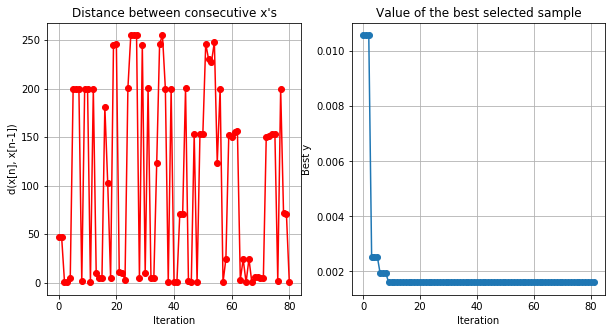

In [27]:
optimized_lstm_model.plot_convergence(filename="convergence.png")
optimized_lstm_model.plot_acquisition(filename="aquisition.png")

In [31]:
print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
\t{18}:\t{19}
\t{20}:\t{21}
""".format(parameter_bounds[0]["name"],optimized_lstm_model.x_opt[0],
           parameter_bounds[1]["name"],optimized_lstm_model.x_opt[1],
           parameter_bounds[2]["name"],optimized_lstm_model.x_opt[2],
           parameter_bounds[3]["name"],optimized_lstm_model.x_opt[3],
           parameter_bounds[4]["name"],optimized_lstm_model.x_opt[4],
           parameter_bounds[5]["name"],optimized_lstm_model.x_opt[5],
           parameter_bounds[6]["name"],int(optimized_lstm_model.x_opt[6]),
           parameter_bounds[7]["name"],int(optimized_lstm_model.x_opt[7]),
           parameter_bounds[8]["name"],int(optimized_lstm_model.x_opt[8]),
           parameter_bounds[9]["name"],int(optimized_lstm_model.x_opt[9]),
           parameter_bounds[10]["name"],int(optimized_lstm_model.x_opt[10])))
          
          
    
print("optimized loss: {0}".format(optimized_lstm_model.fx_opt))



Optimized Parameters:
	l1_dropout:	0.410919405544983
	l2_dropout:	0.2026549324920149
	l3_dropout:	0.20132766526762616
	l4_dropout:	0.20337507747060973
	l5_dropout:	0.7990748026192123
	learning_rate:	0.0994845076611638
	units:	32
	batch_size:	32
	look_back:	30
	epochs:	200
	layers:	3

optimized loss: 0.0016024886248923308


### Build, Train and Predict Values with optimal LSTM

In [34]:
#best parameters
best_dropout_list = []
optimized = True
if optimized == True:
    best_learning_rate = optimized_lstm_model.x_opt[5]
    best_units = int(optimized_lstm_model.x_opt[6])
    best_batch_size = int(optimized_lstm_model.x_opt[7])
    best_look_back = int(optimized_lstm_model.x_opt[8])
    best_epochs = int(optimized_lstm_model.x_opt[9])
    best_layers = int(optimized_lstm_model.x_opt[10])

if optimized == False:
    best_learning_rate = 0.07495698010515113
    best_units = 512
    best_batch_size = 16
    best_look_back = 10
    best_epochs = 100
    best_layers = 3


best_look_ahead = 1
best_features = 1

for layer in range(0, best_layers-2):
    print("Append Dropout for %sst hidden layer: %s to list" % (layer+1, optimized_lstm_model.x_opt[layer]))
    best_dropout_list.append(optimized_lstm_model.x_opt[layer])
    

Append Dropout for 1st hidden layer: 0.410919405544983 to list


In [35]:
print(best_dropout_list, best_learning_rate, 
      int(best_units), int(best_batch_size), int(best_look_back), int(best_epochs), int(best_layers) )

[0.410919405544983] 0.0994845076611638 32 32 30 200 3


In [36]:
X_key_list_stacked_tensor_dict, y_key_list_stacked_tensor_dict = create_Xy_key_list_stacked_tensor(tensor_dict, train_key,
                                                                                                       best_look_back, 
                                                                                                       best_look_ahead)

    
X_scaled_key_list_stacked_tensor_dict, y_scaled_key_list_stacked_tensor_dict = create_Xy_key_list_scaled_stacked_tensor(X_key_list_stacked_tensor_dict,                                                                                                                         y_key_list_stacked_tensor_dict)

look_back: 30
look_ahead: 1
Stacked Sequence Shape: (60000, 17)
X look_back: (59970, 30, 17)
y look_ahead: (59970, 1, 17)


In [37]:
best_lstm_model = stackedLSTM(var_units=best_units, 
                                 var_epochs=best_epochs, 
                                 var_batch_size=best_batch_size, 
                                 var_look_back=best_look_back, 
                                 var_look_ahead=best_look_ahead, 
                                 var_layers=best_layers, 
                                 var_dropout_list=best_dropout_list,
                                 var_learning_rate = best_learning_rate
                                            )

[0.410919405544983]


In [38]:
lstm_model = best_lstm_model.build_model()

dropout l0: 0.410919405544983
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_179 (LSTM)              (None, 32)                4352      
_________________________________________________________________
dropout_179 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 33        
_________________________________________________________________
repeat_vector_83 (RepeatVect (None, 1, 1)              0         
_________________________________________________________________
activation_83 (Activation)   (None, 1, 1)              0         
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [100]:
X_scaled_key_list_stacked_tensor_dict[train_key[0]][:,:,0:1].shape

(59980, 20, 1)

In [39]:
lstm_model.fit(X_scaled_key_list_stacked_tensor_dict[train_key[0]][:,:,0:1], 
               y_scaled_key_list_stacked_tensor_dict[train_key[0]][:,:,0:1],
               epochs=best_epochs,
               verbose=1, 
               validation_data=(X_scaled_key_list_stacked_tensor_dict[train_key[0]][:,:,0:1], 
                                y_scaled_key_list_stacked_tensor_dict[train_key[0]][:,:,0:1]),
                  shuffle = False,
                  callbacks = set_callbacks(),
                  batch_size=best_batch_size
                  )

Train on 59970 samples, validate on 59970 samples
Epoch 1/200
59970/59970 [==============================] - 49s 809us/step - loss: 36299.2248 - val_loss: 0.0038

Epoch 00001: val_loss improved from inf to 0.00381, saving model to save_stacked_checkpoint.keras
Epoch 2/200
59970/59970 [==============================] - 44s 740us/step - loss: 0.0211 - val_loss: 0.0030

Epoch 00002: val_loss improved from 0.00381 to 0.00302, saving model to save_stacked_checkpoint.keras
Epoch 3/200
59970/59970 [==============================] - 44s 741us/step - loss: 0.0191 - val_loss: 0.0029

Epoch 00003: val_loss improved from 0.00302 to 0.00291, saving model to save_stacked_checkpoint.keras
Epoch 4/200
59970/59970 [==============================] - 46s 764us/step - loss: 0.0182 - val_loss: 0.0022

Epoch 00004: val_loss improved from 0.00291 to 0.00222, saving model to save_stacked_checkpoint.keras
Epoch 5/200
59970/59970 [==============================] - 46s 760us/step - loss: 0.0179 - val_loss: 0.002

In [41]:
predictions = lstm_model.predict(X_scaled_key_list_stacked_tensor_dict[train_key[0]][:,:,0:1], verbose=1)

59970/59970 [==============================] - 14s 233us/step


predicted values shape: (59970, 1, 1)
actual values shape: (59970, 1, 1)
predicted values shape: 59970
actual values shape: 59970
residuals shape: 59970


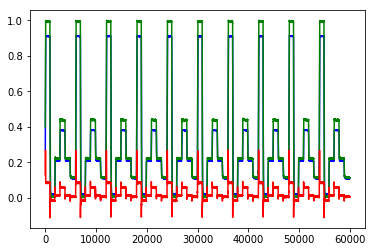

In [43]:
print("predicted values shape: " + str(predictions.shape))
print("actual values shape: " + str(y_scaled_key_list_stacked_tensor_dict[train_key[0]][:,:,0:1].shape))
#print("residuals shape: " + str(residuals[:,:,0:1].shape))

prediction_value_list = predictions.flatten()
actual_value_list = y_scaled_key_list_stacked_tensor_dict[train_key[0]][:,:,0:1].flatten()
residual_value_list = actual_value_list - prediction_value_list

print("predicted values shape: " + str(len(prediction_value_list )))
print("actual values shape: " + str(len(actual_value_list)))
print("residuals shape: " + str(len(residual_value_list)))

residual_list = []
for index in range(1,len(prediction_value_list)):
    #print(index)
    #if index+1 >= len(prediction_value_list):
    #    break
    residual_list.append(actual_value_list[index-2] - prediction_value_list[index])
    
#print(actual_value_list[59979-1])
#print(prediction_value_list[59979])
#print(prediction_value_list[59979] - actual_value_list[59979-1])

plt.plot(prediction_value_list, color="blue")
plt.plot(actual_value_list , color="green")
plt.plot(residual_value_list, color="red")
plt.show()

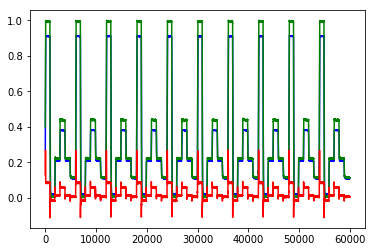

In [44]:
#for feature in range(1,2):
plt.plot(prediction_value_list, color="blue")
plt.plot(actual_value_list , color="green")
plt.plot(residual_value_list, color="red")
plt.show()

from scipy.stats import norm
from scipy.stats import multivariate_normal

In [ ]:
mean = np.mean(train_error_vectors, axis=0)
cov = np.cov(train_error_vectors,rowvar=False)
p_values= multivariate_normal.logpdf(train_error_vectors,mean,cov)

### Plot Features

In [3]:
#function to plot features
def plot_features(feature_dict, feature_list, ceiling=10):
    
    print(feature_list)
    
    for i in range(0,len(feature_dict[feature_list])):
        print("%s of %s" %(i, len(feature_dict[feature_list])))
        plt.subplots(figsize=(20,10))
        plt.plot(feature_dict[feature_list][i])   
        plt.show()
        if i == ceiling-1:
            break

In [4]:
def one_plot_features(feature_dict, feature, ceiling=10):

    plt.figure(figsize=(20,10))

    for i in range(0,6000):
    #plt.figure(figsize=(20,10))
        plt.plot(feature_dict[feature][i])
        if i == ceiling - 1:
            break
        
    plt.show()

In [5]:
def plot_cycles(tensor_dict, firstkey, secondkey=None, begin=0, end=6000, feature=0):
    
    if secondkey == None:
        
        plt.figure(figsize=(20,10))
        plt.plot(tensor_dict[firstkey][begin:end,feature])
        #plt.plot(second_tensor[begin:end,feature])
        plt.show()
    
    else:
        plt.figure(figsize=(20,10))
        plt.plot(tensor_dict[firstkey][begin:end,feature])
        plt.plot(tensor_dict[secondkey][begin:end,feature])
        #plt.plot(second_tensor[begin:end,feature])
        plt.show()

In [ ]:
def plot_cycles_all_features(tensor_dict, firstkey, secondkey=None ):
    
    if secondkey == None: 
        if firstkey in tensor_dict:
            #print(tensor_dict[firstkey].shape[1])
    
            for feat in range(0,tensor_dict[firstkey].shape[1]):
                print(feat)
                plot_cycles(tensor_dict, firstkey, begin=0, end=60000, feature=feat)
         
        else:
            print("combination/tensor doesn't exist")

                
    if secondkey != None:
        if firstkey in tensor_dict:
            #print(tensor_dict[key].shape[1])
    
            for feat in range(0,tensor_dict[firstkey].shape[1]):
                print(feat)
                plot_cycles(tensor_dict, firstkey, secondkey=secondkey, begin=0, end=60000, feature=feat)
        
        else:
            print("combination/tensor doesn't exist")

In [ ]:
'''
    def build_fixed_length_model(self):
        
        if self.fix_stateful == False:
            self.fix_model.add(LSTM( units=self.var_units, 
                                    input_shape=(self.var_look_back, self.fix_features),
                                    activation=self.fix_hidden_activation,
                                    return_sequences= True))
            self.fix_model.add(Dropout(self.var_l1_dropout))
        
        if self.fix_stateful == True:
            self.fix_model.add(LSTM(units=self.var_units, 
                                    batch_input_shape=(self.var_batch_size, self.var_look_back, self.fix_features),
                                    activation=self.fix_hidden_activation,
                                    unroll = True,
                                    return_sequences= True))
            self.fix_model.add(Dropout(self.var_l1_dropout))
            
        
        #hidden 1
        self.fix_model.add(LSTM(self.var_layers, return_sequences=True))
        self.fix_model.add(Dropout(self.var_l2_dropout))
        
        #hidden 2
        self.fix_model.add(LSTM(self.var_layers, return_sequences=True))
        self.fix_model.add(Dropout(self.var_l3_dropout))
        
        #hidden 3
        self.fix_model.add(LSTM(self.var_layers, return_sequences=True))
        self.fix_model.add(Dropout(self.var_l4_dropout))
        
        #hidden 4
        self.fix_model.add(LSTM(self.var_layers, return_sequences=False))
        self.fix_model.add(Dropout(self.var_l5_dropout))
        
        #output
        self.fix_model.add(Dense(output_dim=self.fix_features))
        self.fix_model.add(RepeatVector(self.var_look_ahead))

        #add activation
        self.fix_model.add(Activation("linear"))
        
        self.fix_model.compile(loss=self.fix_loss, optimizer= Adam(lr=self.var_learning_rate, decay=.99))
        
        self.fix_model.summary()
            
        return self.fixed_model
    '''

In [36]:
'''
variabel_length_model_parameter_bounds =[{'name': 'dropout', 'type': 'continuous', 'domain': (0.2, 0.8)},
                   {'name': 'learning_rate', 'type': 'continuous', 'domain': (0.001, .1)},
                   {'name': 'units', 'type': 'discrete', 'domain': (16,32,64,128,256)},
                   {'name': 'batch_size', 'type': 'discrete', 'domain': (8,16,32,64,128)},
                   {'name': 'look_back', 'type': 'discrete', 'domain': (5,10,15,20,25,30,35,40,45,50)},
                   #{'name': 'look_ahead', 'type': 'discrete', 'domain': (1,2,3,4,5)},
                   {'name': 'layers', 'type':'discrete', 'domain':(3,4,5)},
                   {'name': 'epochs', 'type':'discrete', 'domain':(25,50,100,150,200,250,300)}
                 ]
'''

In [37]:
'''
fixed_length_model_parameter_bounds =[{'name': 'l1_dropout', 'type': 'continuous', 'domain': (0.2, 0.8)},
                   {'name': 'l2_dropout', 'type': 'continuous', 'domain': (0.2, 0.8)},
                   {'name': 'l3_dropout', 'type': 'continuous', 'domain': (0.2, 0.8)},
                   {'name': 'l4_dropout', 'type': 'continuous', 'domain': (0.2, 0.8)},
                   {'name': 'l5_dropout', 'type': 'continuous', 'domain': (0.2, 0.8)},
                   {'name': 'learning_rate', 'type': 'continuous', 'domain': (0.001, .1)},
                   {'name': 'units', 'type': 'discrete', 'domain': (16,32,64,126,256)},
                   {'name': 'batch_size', 'type': 'discrete', 'domain': (32,64,128,256,512)},
                   {'name': 'look_back', 'type': 'discrete', 'domain': (5,10,15,20,25,30,35,40,45,50)},
                   #{'name': 'look_ahead', 'type': 'discrete', 'domain': (1,2,3,4,5)},
                   {'name': 'epochs', 'type':'discrete', 'domain':(25,50,100,150,200,250,300)}
                 ]
'''

In [107]:
'''
# Optimization stateful objective function
def stateful_lstm_ojective_function(param):
    
    #validation_loss_list = []
    param = param.flatten()
    fixed = True
        
    fix_optimizers = 'adam'
    fix_learning_rate = 0.5
    fix_loss = 'mse'
    fix_shuffle = False
    fix_patience = 3
        
    if fixed == False:
        var_dropout = float(param[0])
        var_units= int(param[1])
        
        var_batch_size = int(param[2])
        var_look_back = int(param[3])
        var_look_ahead = int(param[4])
        var_layers = int(param[5])
        var_epochs = int(param[6])
        
        print("Using stateful variable length Model HyperParams. dropout:%f, units:%s, batch_size:%s, look_back:%s, look_ahead:%s, layers:%s, epochs:%s" % 
                 (var_dropout, var_units, var_batch_size, var_look_back, var_look_ahead, var_layers, var_epochs))
        
    if fixed == True:
        fix_layers = 6
        print("fix_layers: " + str(fix_layers))
        
        var_l1_dropout = float(param[0])
        var_l2_dropout = float(param[1])
        var_l3_dropout = float(param[2])
        var_l4_dropout = float(param[3])
        var_l5_dropout = float(param[4])
        
        var_units= int(param[5])
        var_batch_size = int(param[6])
        var_look_back = int(param[7])
        var_look_ahead = int(param[8])
        var_epochs = int(param[9])
        
        print(var_look_ahead)
        
        print("Using stateful fixed length Model HyperParams. l1_dropout:%f, l2_dropout:%f, l3_dropout:%f, l4_dropout:%f, l5_dropout:%f, units:%s, batch_size:%s, look_back:%s, look_ahead:%s, layers:%s, epochs:%s" % 
                 (var_l1_dropout, var_l2_dropout, var_l3_dropout, var_l4_dropout, var_l5_dropout,
                  var_units, var_batch_size, var_look_back, var_look_ahead, var_layers, var_epochs))
    
    print("create data Sequence with look_ahead and look_back...")
    X_key_list_stacked_tensor_dict, y_key_list_stacked_tensor_dict = create_Xy_key_list_stacked_tensor(tensor_dict, 
                                                                                                       train_key, 
                                                                                                       var_look_back, 
                                                                                                       var_look_ahead)

    
    
    X_scaled_key_list_stacked_tensor_dict, y_scaled_key_list_stacked_tensor_dict = create_Xy_key_list_scaled_stacked_tensor(X_key_list_stacked_tensor_dict, 
                                                                                                  y_key_list_stacked_tensor_dict)
    
    #print(X_scaled_key_list_stacked_tensor_dict[train_key[0]][:16,1,1])
    #print(y_scaled_key_list_stacked_tensor_dict[train_key[0]][10:16,1,1])
    
    
    #prepare for Stateful LSTM Model
    n_train_batches = int(len(X_scaled_key_list_stacked_tensor_dict[train_key[0]]) / var_batch_size)
    n_validation_batches = int(len(X_scaled_key_list_stacked_tensor_dict[train_key[0]]) / var_batch_size)
    n_test_batches = int(len(X_scaled_key_list_stacked_tensor_dict[train_key[0]]) / var_batch_size)
     
    length_training = n_train_batches * var_batch_size
    length_validation = n_validation_batches * var_batch_size
    length_test = n_test_batches * var_batch_size
    
   # plt.figure(figsize=(20,10))
   # plt.plot(X_scaled_key_list_stacked_tensor_dict[train_key[0]][0:2000,:,1], color="green")
   # plt.plot(y_scaled_key_list_stacked_tensor_dict[train_key[0]][2000:4000,:,1], color="blue")
   # plt.show()
    
    if fixed == False:
        print("initilize Layer variable length stateful LSTM Model...")
        stacked_lstm_model = stackedLSTM(var_units=var_units, var_epochs=var_epochs, var_batch_size=var_batch_size, 
                                         var_look_back=var_look_back, var_look_ahead=var_look_ahead, 
                                         var_layers=var_layers, 
                                         var_dropout=var_dropout, 
                                         fix_stateful=True,
                                         fix_features=17
                                         )
    
    if fixed == True:
        print("initilize fixed lenght Layer for stateful LSTM Model...")
        stacked_lstm_model = stackedLSTM(var_units=var_units, var_epochs=var_epochs, var_batch_size=var_batch_size, 
                                         var_look_back=var_look_back, var_look_ahead=var_look_ahead, var_layers=fix_layers,
                                         var_l1_dropout=var_l1_dropout,
                                         var_l2_dropout=var_l2_dropout,
                                         var_l3_dropout=var_l3_dropout, 
                                         var_l4_dropout=var_l4_dropout, 
                                         var_l5_dropout=var_l5_dropout,
                                         fix_stateful=True
                                            )    
    
    
            
    print("build statefull LSTM model...")
    lstm_model = stacked_lstm_model.build_model()
    
    
    print("train stateful LSTM model...")
    train_model(lstm_model, X_train=X_scaled_key_list_stacked_tensor_dict[train_key[0]][:length_training,:,:], 
                                 y_train=y_scaled_key_list_stacked_tensor_dict[train_key[0]][:length_training,:,:], 
                                 X_test=X_scaled_key_list_stacked_tensor_dict[train_key[0]][:length_training,:,:], 
                                 y_test=y_scaled_key_list_stacked_tensor_dict[train_key[0]][:length_training,:,:], 
                                 var_batch_size=var_batch_size,
                                 var_epochs=var_epochs)
    
    print("evaluate stateful LSTM model...")
    validation_loss = evaluate_model(lstm_model, 
                                     X_scaled_key_list_stacked_tensor_dict[train_key[0]][:length_training,:,:], 
                                     y_scaled_key_list_stacked_tensor_dict[train_key[0]][:length_training,:,:], 
                                     var_batch_size=var_batch_size)

    
    
    return validation_loss
'''

One_to_One Vanilla LSTM

In [83]:
init_1 = RandomUniform(minval=-0.05, maxval=0.05)

#path_checkpoint_1 = '23_checkpoint_h512_s50_PS1.keras'
#path_checkpoint_1 = 'checkpint_h512_s50_PS1_optimzed.keras'
#path_checkpoint_1 = 'checkpint_h512_s50_17to1.keras'
#path_checkpoint_1 = 'checkpoint_2h512_s50_17to1_stacked2.keras'
#path_checkpoint_1 = 'checkpoint_3h512_s50_17to1_stacked3.keras'
#path_checkpoint_1 = 'checkpoint_3h512_s50_17to1_stacked3_rmsprop.keras'
#path_checkpoint_1 = 'checkpoint_1h512_s50_1to1_bidirec.keras'
#path_checkpoint_1 = 'checkpoint_1h512_s5_1to1.keras'
#path_checkpoint_1 = 'checkpoint_2h32_16_s5_17to1_sigmoid.keras'
path_checkpoint_1 = 'checkpoint_2h32_16_lb5_17to1_sigmoid.keras'
#path_checkpoint_1 = 'checkpoint_2h32_16_lb5_1to1_sigmoid.keras'
#path_checkpoint_1 = 'checkpoint_2h17_5_lb5_17to1_sigmoid.keras'
#path_checkpoint_1 = 'checkpoint_2h64_32_lb5_17to1_sigmoid.keras'
#path_checkpoint_1 = 'checkpoint_2h32_16_lb5_17to1_sigmoid_final.keras'
#path_checkpoint_1 = 'checkpoint_2h128_128_lb5_17to1_sigmoid.keras'
callback_checkpoint_1 = ModelCheckpoint(filepath=path_checkpoint_1,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping_1 = EarlyStopping(monitor='val_loss',
                                        patience=10, verbose=1)

callback_tensorboard_1 = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

callback_reduce_lr_1 = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-7,
                                       patience=0,
                                       verbose=1)

callbacks_1 = [callback_early_stopping_1,
             callback_checkpoint_1,
             callback_tensorboard_1,
             callback_reduce_lr_1]

In [84]:
n_steps, var_look_back=[5,5]
var_look_ahead=1
train_key=['c100_h130_pl0_v100_s0']
#val_key=['c100_h130_pl0_v100_s0']
val_key=['c100_h130_pl0_v90_s0']

X_key_list_stacked_tensor_dict_train, y_key_list_stacked_tensor_dict_train = create_Xy_key_list_stacked_tensor(tensor_dict, train_key,
                                                                                                       var_look_back, 
                                                                                                       var_look_ahead)

#val data
X_key_list_stacked_tensor_dict_val, y_key_list_stacked_tensor_dict_val = create_Xy_key_list_stacked_tensor(tensor_dict, val_key,
                                                                                                       var_look_back, 
                                                                                                       var_look_ahead)

    
    
#train dta
X_scaled_key_list_stacked_tensor_dict_train, y_scaled_key_list_stacked_tensor_dict_train = create_Xy_key_list_scaled_stacked_tensor(X_key_list_stacked_tensor_dict_train, 
                                                                                                                            y_key_list_stacked_tensor_dict_train)

    
X_scaled_key_list_stacked_tensor_dict_val, y_scaled_key_list_stacked_tensor_dict_val = create_Xy_key_list_scaled_stacked_tensor(X_key_list_stacked_tensor_dict_val, 
                                                                                                                            y_key_list_stacked_tensor_dict_val)


look_back: 5
look_ahead: 1
Stacked Sequence Shape: (60000, 17)
X look_back: (59995, 5, 17)
y look_ahead: (59995, 1, 17)
look_back: 5
look_ahead: 1
Stacked Sequence Shape: (60000, 17)
X look_back: (59995, 5, 17)
y look_ahead: (59995, 1, 17)


In [84]:
n_features=1
n_output_features = 1
adam= optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
print(n_features)

model_vanilla_1 = Sequential()
model_vanilla_1.add(LSTM(512, activation='relu', input_shape=(n_steps, n_features)))
#model_vanilla_1.add(LSTM(512, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
#model_vanilla_1.add(LSTM(512, activation='relu', input_shape=(n_steps, n_features)))
model_vanilla_1.add(Dense(1,activation='linear',
                    #output_dim=n_output_features,
                    kernel_initializer=init_1))
model_vanilla_1.add(RepeatVector(var_look_ahead))
### load weights from pretrained model
#model_vanilla_1.load_weights("23_checkpoint_h512_s50_PS1.keras")
###
model_vanilla_1.compile(optimizer=adam, loss='mse')
model_vanilla_1.summary()

1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 512)               1052672   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
_________________________________________________________________
repeat_vector_11 (RepeatVect (None, 1, 1)              0         
Total params: 1,053,185
Trainable params: 1,053,185
Non-trainable params: 0
_________________________________________________________________


In [76]:
start_time = datetime.datetime.now() 

model_vanilla_1.fit(X_scaled_key_list_stacked_tensor_dict_train[train_key[0]][:,:,0:n_features], y_scaled_key_list_stacked_tensor_dict_train[train_key[0]][:,:,0:1],
                  epochs=50,
                  batch_size=1,
                  verbose=1,
                  validation_data=(X_scaled_key_list_stacked_tensor_dict_val[val_key[0]][:,:,0:n_features], y_scaled_key_list_stacked_tensor_dict_val[val_key[0]][:,:,0:1]),
                  shuffle=False,
                  callbacks=callbacks_1)
    #reset model to learn from beginning
    #model_vanilla.reset_states()

time_elapsed = datetime.datetime.now() - start_time 
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

NameError: name 'model_vanilla_1' is not defined

In [96]:
n_features=17
n_output_features = 1
adam= optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
print(n_features)

model_vanilla_sigmoid_small = Sequential()
model_vanilla_sigmoid_small.add(LSTM(64, activation='sigmoid', input_shape=(n_steps, n_features), return_sequences=True))
model_vanilla_sigmoid_small.add(LSTM(32, activation='sigmoid', input_shape=(n_steps, n_features)))
#model_vanilla_1.add(LSTM(512, activation='relu', input_shape=(n_steps, n_features)))
model_vanilla_sigmoid_small.add(Dense(1,activation='linear',
                    #output_dim=n_output_features,
                    kernel_initializer=init_1))
model_vanilla_sigmoid_small.add(RepeatVector(var_look_ahead))

### load weights from pretrained model
#model_vanilla_sigmoid_small.load_weights("checkpoint_2h32_16_s5_17to1_sigmoid.keras")
###

model_vanilla_sigmoid_small.compile(optimizer=adam, loss='mse')
model_vanilla_sigmoid_small.summary()

17
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 5, 64)             20992     
_________________________________________________________________
lstm_22 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
_________________________________________________________________
repeat_vector_11 (RepeatVect (None, 1, 1)              0         
Total params: 33,441
Trainable params: 33,441
Non-trainable params: 0
_________________________________________________________________


In [97]:
start_time = datetime.datetime.now() 

model_vanilla_sigmoid_small.fit(X_scaled_key_list_stacked_tensor_dict_train[train_key[0]][:,:,0:n_features], y_scaled_key_list_stacked_tensor_dict_train[train_key[0]][:,:,0:1],
                  epochs=20,
                  batch_size=1,
                  verbose=1,
                  validation_data=(X_scaled_key_list_stacked_tensor_dict_val[val_key[0]][:,:,0:n_features], y_scaled_key_list_stacked_tensor_dict_val[val_key[0]][:,:,0:1]),
                  shuffle=False,
                  callbacks=callbacks_1)
    #reset model to learn from beginning
    #model_vanilla.reset_states()

time_elapsed = datetime.datetime.now() - start_time 
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Train on 59995 samples, validate on 59995 samples
Epoch 1/20
59995/59995 [==============================] - 719s 12ms/step - loss: 4.0643e-05 - val_loss: 0.1113

Epoch 00001: val_loss did not improve from 0.00018
Epoch 2/20
59995/59995 [==============================] - 866s 14ms/step - loss: 0.0013 - val_loss: 0.0272

Epoch 00002: val_loss did not improve from 0.00018
Epoch 3/20
59995/59995 [==============================] - 888s 15ms/step - loss: 3.5643e-04 - val_loss: 0.0502 - ET - ET - ETA: 0s - loss: 3.5645e-0

Epoch 00003: val_loss did not improve from 0.00018

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/20
59995/59995 [==============================] - 620s 10ms/step - loss: 0.0016 - val_loss: 0.0024

Epoch 00004: val_loss did not improve from 0.00018
Epoch 5/20
59995/59995 [==============================] - 631s 11ms/step - loss: 6.0844e-04 - val_loss: 4.9211e-04

Epoch 00005: val_loss did not improve from 0.00018
Epoch 6/20
59995/59

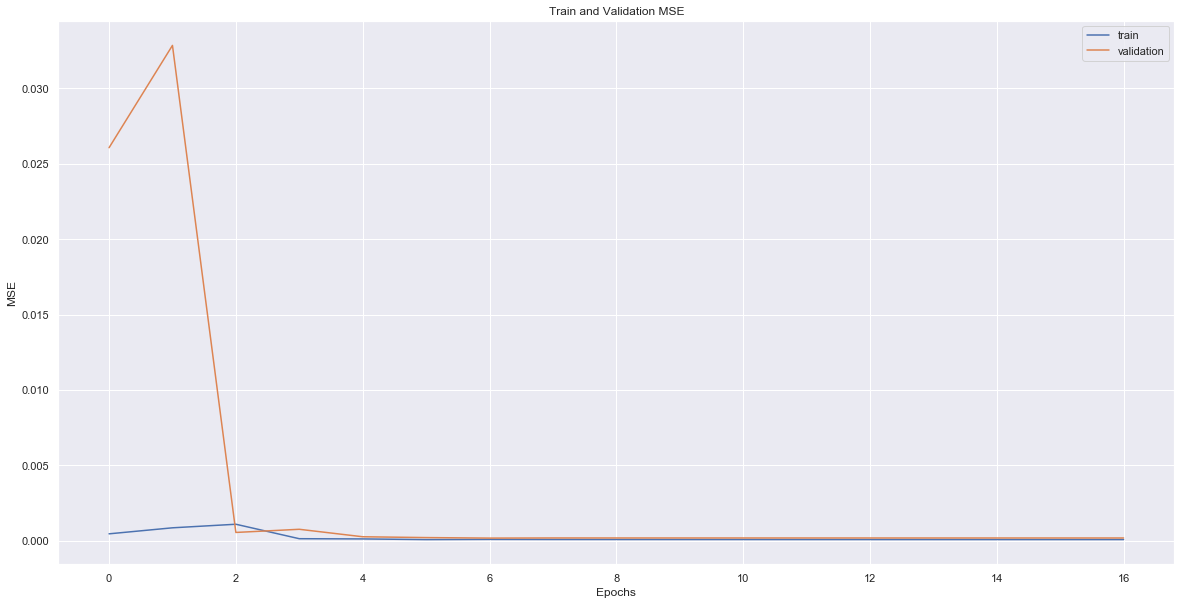

In [87]:
import seaborn as sns
sns.set()

plt.figure(figsize=(20,10))
plt.plot(model_vanilla_sigmoid_small.history.history['loss'], label='train')
plt.plot(model_vanilla_sigmoid_small.history.history['val_loss'], label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Train and Validation MSE")
plt.show()

In [106]:
#model_vanilla_small_sigmoid_predictions = model_vanilla_small_sigmoid.predict(X_scaled_key_list_stacked_tensor_dict_val[val_key[0]][:,:,0:n_features], verbose=1)
model_vanilla_small_sigmoid_predictions = model_vanilla_sigmoid_small.predict(X_scaled_key_list_stacked_tensor_dict_train[train_key[0]][:,:,0:n_features], verbose=1)

59995/59995 [==============================] - 4s 64us/step


predicted values shape: (59980, 1, 1)
actual values shape: (59995, 1, 1)


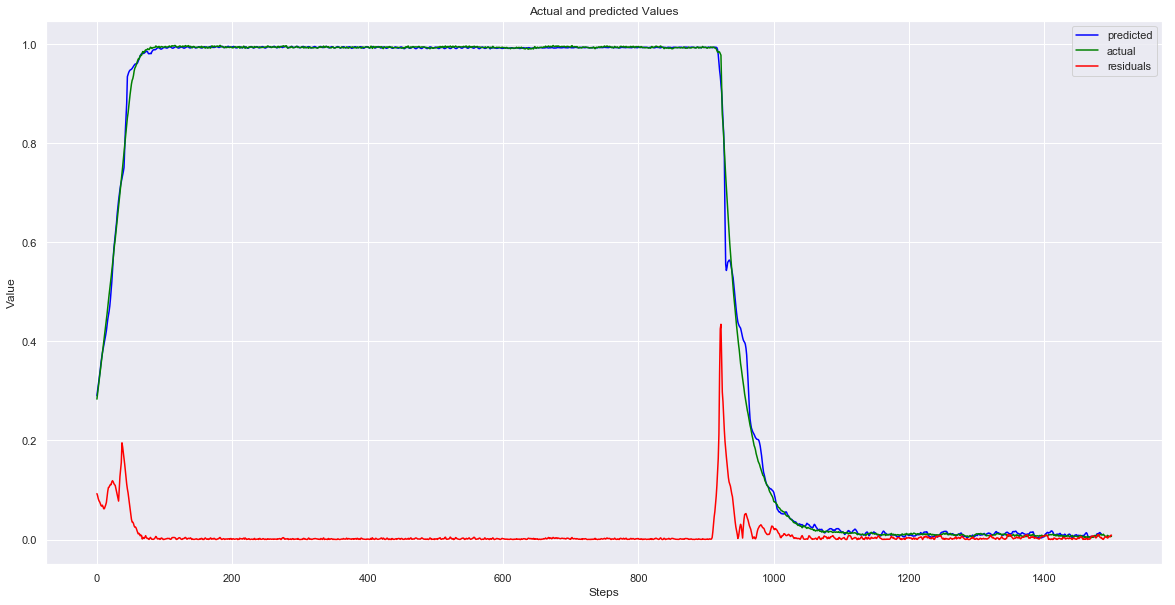

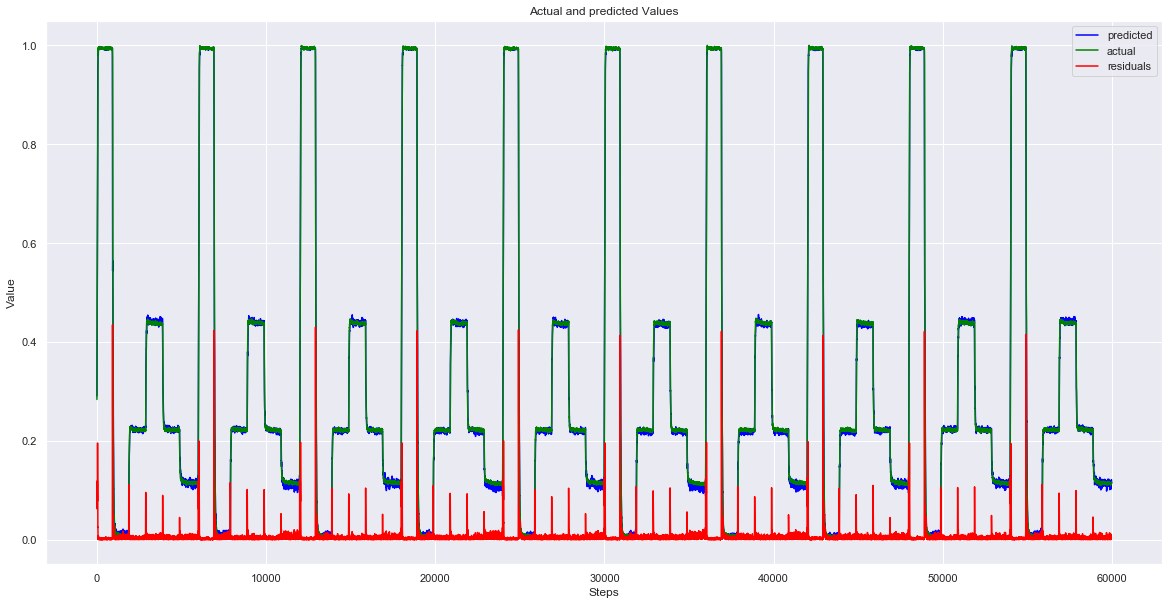

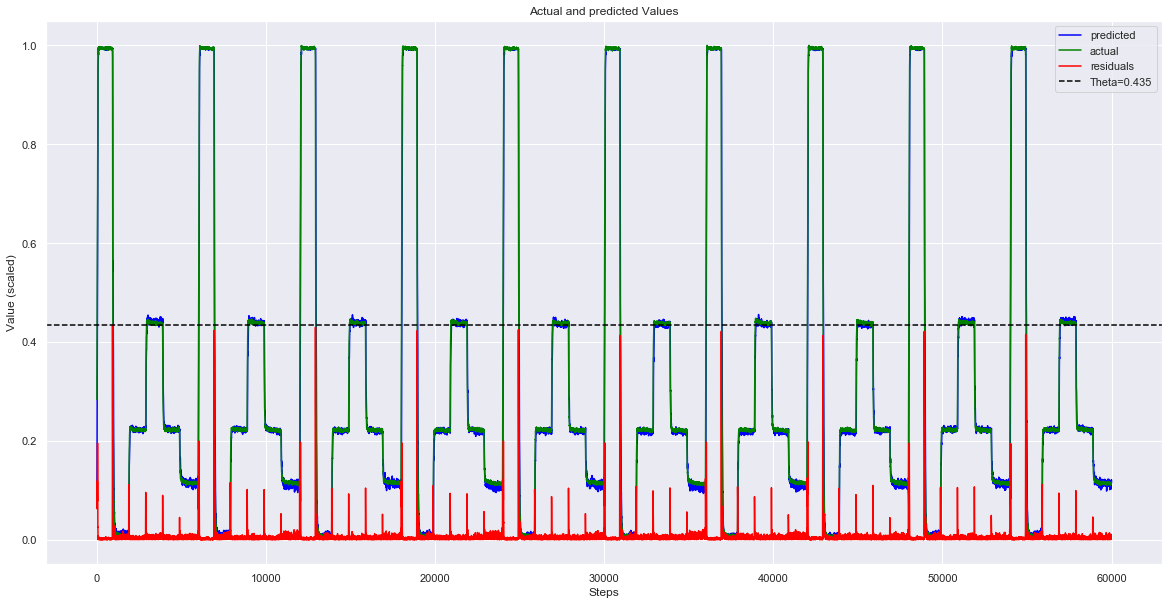

In [107]:
print("predicted values shape: " + str(model_vanilla_small_sigmoid_predictions[15:].shape))
print("actual values shape: " + str(y_scaled_key_list_stacked_tensor_dict_train[train_key[0]][:,:,0:1].shape))
#print("residuals shape: " + str(residuals[:,:,0:1].shape))

shift=23
start=0
end=6000


prediction_value_list = model_vanilla_small_sigmoid_predictions.flatten()
actual_value_list = y_scaled_key_list_stacked_tensor_dict[train_key[0]][:,:,0:1].flatten()
#residual_value_list = abs(actual_value_list[shift:] - prediction_value_list[0:len(actual_value_list)-shift])

s = len(prediction_value_list[shift:])
residual_value_list = abs(prediction_value_list[shift:] - actual_value_list[:s])
sorted_residuals= np.sort(residual_value_list)


plt.figure(figsize=(20,10))
plt.plot(prediction_value_list[15:1500], color="blue", label='predicted')
plt.plot(actual_value_list[:1500], color="green", label='actual')
plt.plot(residual_value_list[:1500] , color="red", label='residuals')
#plt.axhline(y=sorted_residuals[-4] , linestyle='dashed' ,color="black", label='Threshold')
#plt.yticks([theta], label="test")
plt.legend()
plt.xlabel("Steps")
plt.ylabel("Value")
plt.title("Actual and predicted Values")
plt.show()



plt.figure(figsize=(20,10))
plt.plot(prediction_value_list[15:], color="blue", label='predicted')
plt.plot(actual_value_list[:], color="green", label='actual')
plt.plot(residual_value_list[:] , color="red", label='residuals')
#plt.axhline(y=sorted_residuals[-4] , linestyle='dashed' ,color="black", label='Threshold')
#plt.yticks([theta], label="test")
plt.legend()
plt.xlabel("Steps")
plt.ylabel("Value")
plt.title("Actual and predicted Values")
plt.show()



plt.figure(figsize=(20,10))
plt.plot(prediction_value_list[:], color="blue", label='predicted')
plt.plot(actual_value_list[:], color="green", label='actual')
plt.plot(residual_value_list[:] , color="red", label='residuals')
plt.axhline(y=max(residual_value_list) , linestyle='dashed' ,color="black", label='Theta=' + str(round(max(residual_value_list),3)))
#plt.yticks([theta], label="test")
plt.legend()
plt.xlabel("Steps")
plt.ylabel("Value (scaled)")
plt.title("Actual and predicted Values")
plt.show()

In [61]:
from scipy.stats import norm, normaltest, shapiro
from scipy.stats import multivariate_normal


residual_value_list=list(residual_value_list)
mean = np.mean(residual_value_list)
cov = np.cov(residual_value_list)
print(mean)
print(cov)

#k2 , p = normaltest(residual_value_list)

#print(p)

shapiro(residual_value_list)

0.00512486397064678
0.00016332363472167593


 c:\users\mooc\appdata\local\continuum\anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning:p-value may not be accurate for N > 5000.


(0.3193497061729431, 0.0)

In [356]:
#qqplot(np.exp(residual_value_list), line='s')

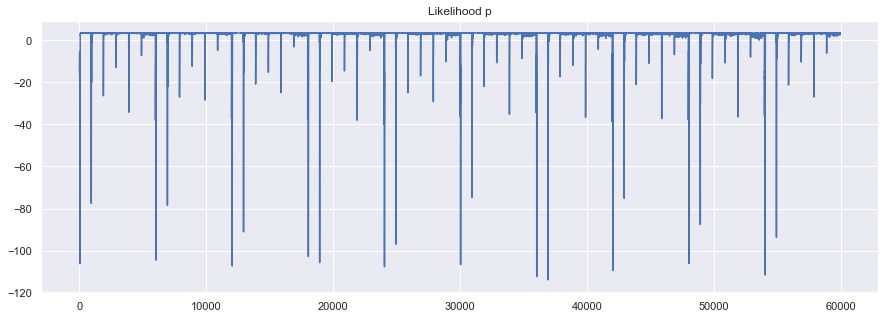

In [103]:
#residual_value_list.append(0.13)

p_values_logpdf= multivariate_normal.logpdf(residual_value_list[:],mean,cov)
p_values_pdf= multivariate_normal.pdf(residual_value_list[:],mean,cov)

#print(p_values)

plt.figure(figsize=(15,5))
plt.plot(p_values_logpdf[:])
plt.title("Likelihood p")
plt.show()

#plt.figure(figsize=(15,5))
#plt.plot(p_values_pdf[:])
#plt.title("pdf")
#plt.show()

17_to_One LSTM